# Pandas vs Dask Dataframe using Wikilink Dataset Handling Large Data 

https://towardsdatascience.com/how-to-handle-large-datasets-in-python-with-pandas-and-dask-34f43a897d55

In [1]:
import pandas as pd 

In [2]:
df=pd.read_csv('C:\\worked\\Data_science\\ML-Deployment\\clickstream-enwiki-2018-12\\clickstream-enwiki-2018-12.tsv',delimiter='\t')

In [3]:
df.head()

,other-empty,2019_Horizon_League_Baseball_Tournament,external,16
0,other-search,ForeverAtLast,external,40
1,other-empty,ForeverAtLast,external,85
2,First_Families_of_Pakistan,Jehangir_Wadia,link,19
3,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36
4,Wadia_family,Jehangir_Wadia,link,715


In [4]:
df.columns=['coming_from', 'article', 'referrer_type','n']

In [5]:
df.head()

,coming_from,article,referrer_type,n
0,other-search,ForeverAtLast,external,40
1,other-empty,ForeverAtLast,external,85
2,First_Families_of_Pakistan,Jehangir_Wadia,link,19
3,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36
4,Wadia_family,Jehangir_Wadia,link,715


In [6]:
df.dtype={'referrer_type':'category','n':'uint32'}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [18]:
df.head()

,coming_from,article,referrer_type,n
0,other-search,ForeverAtLast,external,40
1,other-empty,ForeverAtLast,external,85
2,First_Families_of_Pakistan,Jehangir_Wadia,link,19
3,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36
4,Wadia_family,Jehangir_Wadia,link,715


In [19]:
df = df.iloc[:100000]

In [20]:
df.shape

(100000, 4)

In [21]:
top_links = df.loc[df['referrer_type'].isin(['link']),['coming_from','article', 'n']].groupby(['coming_from', 'article']).sum().sort_values(by='n',ascending=False)

In [22]:
top_links

,,n
coming_from,article,
Cardi_B,Invasion_of_Privacy_(album),28250
List_of_Bollywood_films_of_2018,Zero_(2018_film),24835
Rashida_Jones,Kidada_Jones,24616
Shah_Rukh_Khan_filmography,Zero_(2018_film),18435
Peggy_Lipton,Kidada_Jones,17483
...,...,...
Germany_at_the_2016_Summer_Olympics,Shooting_at_the_2016_Summer_Olympics,10
Quinn,List_of_Major_League_Baseball_players_with_unidentified_given_names,10
Germans,Downfall_(2004_film),10


# Create DASK Dataframe

In [23]:
from dask import dataframe as dd 


In [24]:
dfd = dd.read_csv('C:\\worked\\Data_science\\ML-Deployment\\clickstream-enwiki-2018-12\\clickstream-enwiki-2018-12.tsv',delimiter='\t',names=['coming_from','article','referrer_type','n'],
    dtype={
        'referrer_type': 'category', 
        'n': 'uint32'},
    blocksize=64000000 # = 64 Mb chunks
)

In [26]:
dfd

,coming_from,article,referrer_type,n
npartitions=22,,,,
,object,object,category[unknown],uint32
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [27]:
top_links_grouped_dask = dfd.loc[dfd['referrer_type'].isin(['link']),['coming_from','article','n']].groupby(['coming_from','article'])

In [28]:
top_links_grouped_dask

In [42]:
store = pd.HDFStore('C:\\worked\\Data_science\\ML-Deployment\\clickstream-enwiki-2018-12\\clickstream_store.h5')

In [43]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: C:\worked\Data_science\ML-Deployment\clickstream-enwiki-2018-12\clickstream_store.h5

In [29]:
top_links_dask = top_links_grouped_dask.sum().nlargest(20,'n').compute()

In [30]:
top_links_dask

n
coming_from       article                                       
Jason_Momoa       Lisa_Bonet                             1166522
Priyanka_Chopra   Nick_Jonas                              596798
Bird_Box          Bird_Box_(film)                         508241
Nick_Jonas        Priyanka_Chopra                         493898
George_H._W._Bush George_W._Bush                          453809
                  Pauline_Robinson_Bush                   419132
                  Barbara_Bush                            412565
George_W._Bush    George_H._W._Bush                       393452
George_H._W._Bush Dorothy_Bush_Koch                       377785
Emily_Atack       Kate_Robbins                            354577
Macaulay_Culkin   Brenda_Song                             346110
George_H._W._Bush Marvin_Bush                             339241
                  Neil_Bush                               330132
Lisa_Bonet        Jason_Momoa                             321970
Bird_Box_(film)   Trevante_Rhodes                         309028
Penny_Marshall    Tracy_Reiner                            281911
George_H._W._Bush Prescott_Bush                           253973
Welcome_to_Marwen Marwencol_(film)                        253955
Lisa_Bonet        Zoë_Kravitz                             250392
2.0_(film)        List_of_highest-grossing_Indian_films   249322

In [47]:
store.put('top_links_dask',
           top_links_dask.compute(),
           format='table',
           data_columns=True)

,n
npartitions=1,
,uint32
,...


In [50]:
external_searches_dask = dfd.loc[(dfd['referrer_type'].isin(['external'])) & (dfd['coming_from'].isin(['other-search'])), ['article','n']]

In [51]:
external_searches_dask = external_searches_dask.nlargest(40,'n').compute()

In [52]:
external_searches_dask

,article,n
631896,George_H._W._Bush,4576854
588296,Jason_Momoa,3538068
525002,2.0_(film),3475113
438090,Bird_Box_(film),3251996
1019396,Main_Page,3020671
177358,Aquaman_(film),2634665
912864,Bird_Box,2328884
639979,Priyanka_Chopra,2231176
980377,List_of_most-disliked_YouTube_videos,2226602
1260730,Freddie_Mercury,2050628


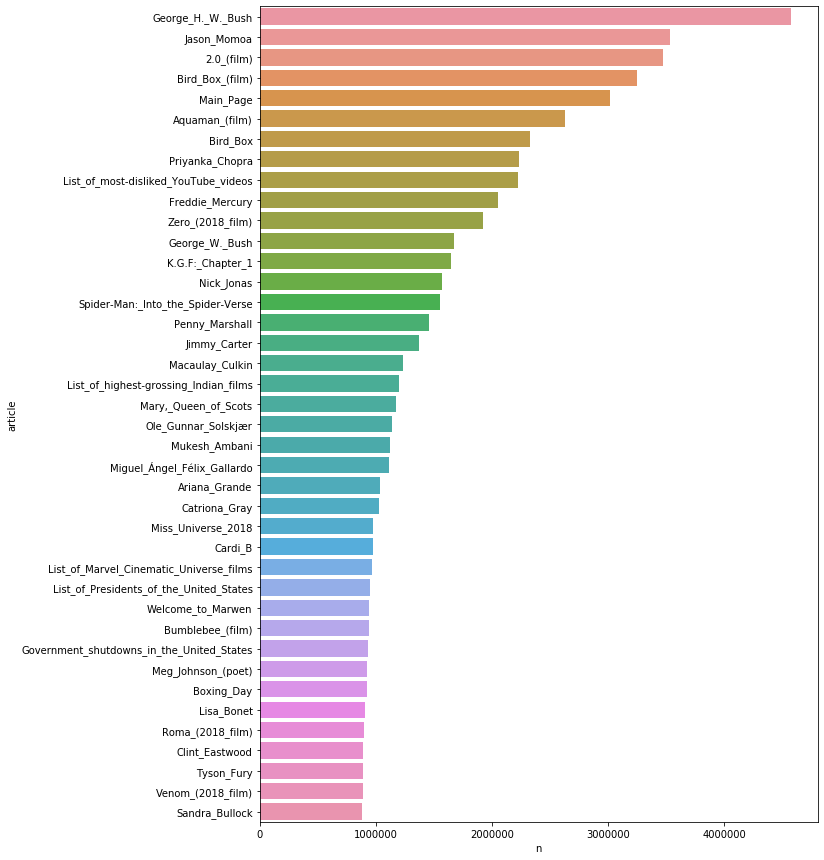

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
a4_dims = (10, 15)
fig, ax = plt.subplots(figsize=a4_dims)
#plt.figsize=(20,20)
sns.barplot(data=external_searches_dask,y='article', x='n')
#plt.gca().set_ylabel('')

In [75]:
df.memory_usage()

Index               128
coming_from      800000
article          800000
referrer_type    800000
n                800000
dtype: int64

What percentage of visitors to a given article page have clicked on a link to get there?

In [89]:
def visitors_clicked_link_pandas(dataframe,article):
    df_article=dataframe.loc[dataframe['article'].isin([article])]
    a=df_article['n'].sum()
    l=df_article.loc[df_article['referrer_type'].isin(['link']),'n'].sum()
    return round((l*100)/a,2)

In [88]:
df.loc[df['article'].isin(['Jehangir_Wadia'])]
#l=df_article.loc[df_article['referrer_type'].isin(['link']),'n'].sum()

,coming_from,article,referrer_type,n
2,First_Families_of_Pakistan,Jehangir_Wadia,link,19
3,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36
4,Wadia_family,Jehangir_Wadia,link,715
5,other-search,Jehangir_Wadia,external,967
6,Ness_Wadia,Jehangir_Wadia,link,494
7,other-empty,Jehangir_Wadia,external,638
8,GoAir,Jehangir_Wadia,link,1191
9,other-internal,Jehangir_Wadia,external,28
10,Lovji_Nusserwanjee_Wadia,Jehangir_Wadia,link,23
11,Sangh_Parivar,Jehangir_Wadia,link,25


In [92]:
visitors_clicked_link_pandas(df,'Jehangir_Wadia')
#visitors_clicked_link_pandas(df,'Priyanka_Chopra')

81.1

Using Dask Dataframe

In [95]:
def visitors_clicked_link_dask(dataframe,article):
	df_article=dataframe.loc[dataframe['article'].isin([article])]
	a=df_article['n'].sum().compute()
	l=df_article.loc[df_article['referrer_type'].isin(['link']),'n'].sum().compute()
	return round((l*100)/a,2)

In [96]:
visitors_clicked_link_dask(dfd,'Jehangir_Wadia')

81.1

What is the most common source of visits for each article?

In [103]:
summed_articles=df.groupby(['article','coming_from']).sum()

In [104]:
summed_articles.head(10)

n
article         coming_from                               
!Kung_languages Central_!Kung                           13
                Contents_of_the_Voyager_Golden_Record  107
                Ekoka_!Kung                             26
                German_language                         17
                Khoe_languages                          17
                Khoekhoe_language                       22
                Khoisan                                 10
                Khoisan_languages                      126
                Kwadi_language                          14
                Languages_of_Angola                     50

In [106]:
max_n_filter = summed_articles.reset_index().groupby('article').idxmax()
max_n_filter 

,n
article,
!Kung_languages,21
"$1,000_genome",30
'S_Out,31
(120132)_2003_FY128,38
(391211)_2006_HZ51,39
...,...
Șirăuți,99992
Șomcuta_Mare,99995
Șteaza_River_(Lotru),99996


In [108]:
summed_articles.iloc[max_n_filter['n']].head(10)

,,n
article,coming_from,
!Kung_languages,other-empty,1464
"$1,000_genome",other-search,801
'S_Out,Bottom_(TV_series),92
(120132)_2003_FY128,other-empty,17
(391211)_2006_HZ51,other-empty,11
(444030)_2004_NT33,other-empty,45
(495603)_2015_AM281,other-empty,26
(Methionine_synthase)_reductase,other-search,35
(Si_Si)_Je_Suis_un_Rock_Star,other-search,168


In [111]:
summed_articles.iloc[max_n_filter['n']].sort_values(by='n', ascending=False).head(10)

,,n
article,coming_from,
Zero_(2018_film),other-search,1923035
College_Football_Playoff,other-search,298487
Attack_on_Pearl_Harbor,other-search,292416
O._J._Simpson,other-search,168402
Outlaw_King,other-search,151554
MS_Dhoni,other-search,143811
Saint_Petersburg,other-external,99437
Seth_Curry,other-search,97616
Mark_Harmon,other-search,88395


# Using Dask

In [31]:
summed_articles = dfd.groupby(['article', 'coming_from']).sum().reset_index().compute()


In [117]:
dfd.groupby(['article','coming_from']).sum().reset_index().to_parquet('C:\\worked\\Data_science\\ML-Deployment\\clickstream-enwiki-2018-12\\summed_articles.parquet', engine='pyarrow')

In [118]:
dfd[['article', 'coming_from']].drop_duplicates().to_parquet('C:\\worked\\Data_science\\ML-Deployment\\clickstream-enwiki-2018-12\\uniques.parquet')

In [ ]:
for item in pd.read_parquet('C:\\worked\\Data_science\\ML-Deployment\\clickstream-enwiki-2018-12\\uniques.parquet',engine='pyarrow').itertuples():
    t = dfd.groupby(['article','coming_from']).get_group(item).compute()

In [9]:
import mysql.connector

In [10]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password=""
)


In [11]:
print(mydb)
mycursor = mydb.cursor()

mycursor.execute("SHOW DATABASES")

for x in mycursor:
  print(x)




('information_schema',)
('mysql',)
('performance_schema',)
('sys',)
('webserv',)


In [39]:
!pip install pymysql

In [43]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://root:''@localhost/webserv')    
df = pd.read_sql('SHOW DATABASES', engine)
df

,Database
0,information_schema
1,mysql
2,performance_schema
3,sys
4,webserv


In [33]:
summed_articles = dfd.groupby(['article','coming_from']).sum().reset_index().compute()

In [34]:
for c in ['\t', '\n', '\\']:
    summed_articles['article'] = summed_articles['article'].str.replace(c, ' ')

In [35]:
summed_articles['coming_from'] = summed_articles['coming_from'].str.replace('\t', ' ')

In [48]:
summed_articles

,article,coming_from,n
0,!Kung_languages,Central_!Kung,13
1,!Kung_languages,Contents_of_the_Voyager_Golden_Record,107
2,!Kung_languages,Ekoka_!Kung,26
3,!Kung_languages,German_language,17
4,!Kung_languages,Khoe_languages,17
...,...,...,...
29843876,東海,other-empty,33
29843877,東海,other-internal,10
29843878,猫_シ_Corp.,other-empty,36
29843879,猫_シ_Corp.,other-external,27


In [66]:
df2=pd.DataFrame(columns=summed_articles.columns).to_sql(
    'summed_articles', 
    con=engine, 
    if_exists='replace', 
    index=False)

In [69]:
print(summed_articles)

                  article                            coming_from    n
0         !Kung_languages                          Central_!Kung   13
1         !Kung_languages  Contents_of_the_Voyager_Golden_Record  107
2         !Kung_languages                            Ekoka_!Kung   26
3         !Kung_languages                        German_language   17
4         !Kung_languages                         Khoe_languages   17
...                   ...                                    ...  ...
29843876               東海                            other-empty   33
29843877               東海                         other-internal   10
29843878        猫_シ_Corp.                            other-empty   36
29843879        猫_シ_Corp.                         other-external   27
29843880        猫_シ_Corp.                         other-internal   20

[29843881 rows x 3 columns]


In [61]:
for n in range(summed_articles,'npartitions'):
    table_chunk = summed_articles.get_partition(n).compute()
    output = io.StringIO()
    table_chunk.to_csv(output, sep='\t', header=False, index=False)
    output.seek(0)
    try:
        cur.copy_from(output, 'summed_articles', null="")
    except Exception:
        err_tables.append(table_chunk)
        conn.rollback()
        continue
    conn.commit()

TypeError: 'DataFrame' object cannot be interpreted as an integer